### Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2lab
from skimage.filters import threshold_otsu
from skimage.morphology import opening, dilation, disk

In [2]:
# Set up the dataset path
dataset_path = '.'

# Set up saving figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "InceptionResNetV2_Improved_Morphology"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)  # create the sub-folders if they do not exist

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

print('> SETUP Done: all saved files are accessible in ', IMAGES_PATH)

> SETUP Done: all saved files are accessible in  .\images\InceptionResNetV2_Improved_Morphology


In [3]:
# Setting all the parameters or hyperparameters
img_size = 128
test_size = 0.3
random_state = 42
validation_split = 0.2
epochs = 20
batch_size = 32
learning_rate = 0.0001

### Loading & preprocessing Data
NEW: Morphological Preprocessing:

- Added conversion of RGB images to LAB color space.
- Used the A channel for segmentation.
- Applied Otsu's thresholding, opening, and dilation for better segmentation.
- Masked the original images to keep only the cotton canopy.

Concerned classes:  ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']
Saving figure Preprocessing_Visualization


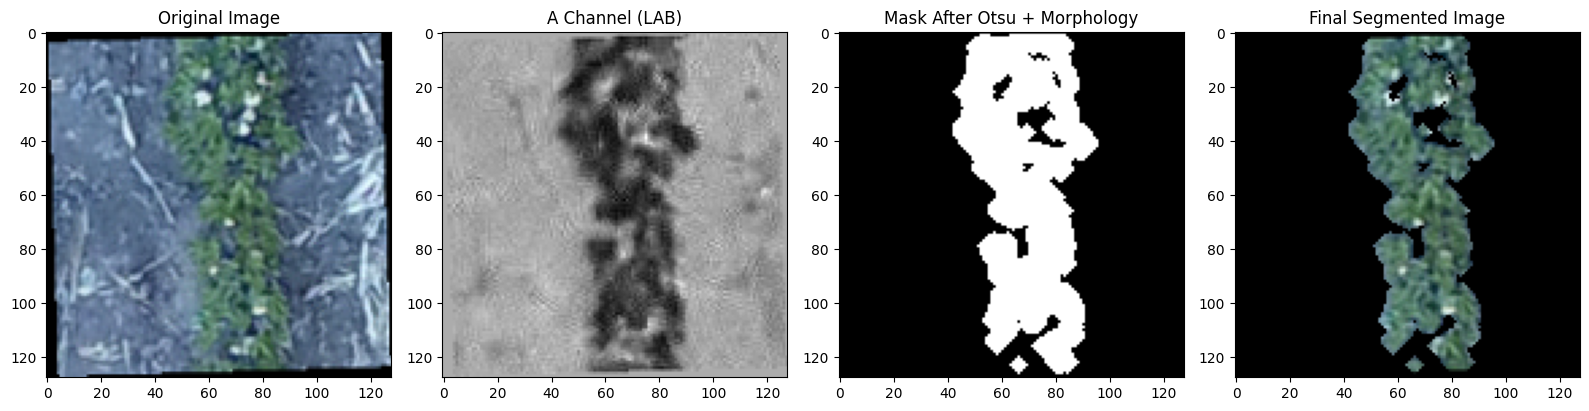

> Preprocessing and splitting done.


In [4]:
def preprocess_images(data):
    preprocessed_data = []
    for i in range(len(data)):
        # Normalize the image
        image = data[i] / 255.0
        
        # Convert to LAB color space and use the A channel for segmentation
        lab_image = rgb2lab(image)
        a_channel = lab_image[:, :, 1]
        
        # Apply Otsu's method for thresholding
        threshold = threshold_otsu(a_channel)
        mask = a_channel < threshold
        
        # Apply morphological operations for refinement
        mask = opening(mask, disk(2))
        mask = dilation(mask, disk(1))

        # Apply the mask to retain only the cotton canopy
        selection = image.copy()
        selection[~mask] = 0
        preprocessed_data.append(selection)
        
        # Visualize each step
        if i == 0:  # Visualize only the first image for demonstration
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            axes[0].imshow(image)
            axes[0].set_title("Original Image")
            axes[1].imshow(a_channel, cmap="gray")
            axes[1].set_title("A Channel (LAB)")
            axes[2].imshow(mask, cmap="gray")
            axes[2].set_title("Mask After Otsu + Morphology")
            axes[3].imshow(selection)
            axes[3].set_title("Final Segmented Image")
            plt.tight_layout()
            save_fig("Preprocessing_Visualization")
            plt.show()
    
    return np.array(preprocessed_data)

# Load and preprocess the data
date = "8_18"  # Example date
data = np.load(f'{dataset_path}/twri_rgb_6832_cotton_{img_size}x{img_size}_{date}.npy')
labels = pd.read_excel(f'{dataset_path}/labels_rgb.xlsx')  # Replace with actual label file
y_label = labels['class'].values

# Filter out unwanted classes
filtered_data = []
filtered_labels = []
for img, label in zip(data, y_label):
    if label != 0:  # Remove filler type
        filtered_data.append(img)
        filtered_labels.append(label - 1)

data = np.array(filtered_data)
y_label = np.array(filtered_labels)

# Define class names
class_names = ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']
print('Concerned classes: ', class_names)

# Apply preprocessing
original_data = data
data = preprocess_images(data)

# Train-test split
train_images, test_images, train_labels, test_labels = train_test_split(data, y_label, test_size=test_size, random_state=random_state)

print("> Preprocessing and splitting done.")

### Build & Train the model
Use transfer learning to start from a pretrained inception model (InceptionResNetV2), but this time, we leave the last 50 layers to be re-trained over our dataset (not only the last custum Dense layers added) : fine-tuning

In [7]:
# MODEL BUILDING & TRAINING
def build_and_train_model(img_size, train_images, train_labels, validation_split, epochs, batch_size, learning_rate):
    print('> Building the model ... ')

    # Build the model using InceptionResNetV2
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    # Fine-tune the model: Unfreeze the last few layers
    for layer in base_model.layers[:-50]:  # Freeze all but the last 50 layers
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x) # increase the nb neurons for more feature map capture
    x = Dropout(0.3)(x)
    output = Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print('> Training in progress ... ')
    # Train the model
    history = model.fit(train_images,
                        train_labels,
                        validation_split = validation_split,
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 1)

    print('> End of Training !')
    return model, history

# Execute
model, history = build_and_train_model(img_size, train_images, train_labels, validation_split, epochs, batch_size, learning_rate)

> Building the model ... 

> Training in progress ... 
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 708ms/step - accuracy: 0.4328 - loss: 1.2026 - val_accuracy: 0.6308 - val_loss: 0.8506
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 861ms/step - accuracy: 0.6525 - loss: 0.7836 - val_accuracy: 0.6985 - val_loss: 0.7381
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 872ms/step - accuracy: 0.7640 - loss: 0.5774 - val_accuracy: 0.7131 - val_loss: 0.7114
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 135s 802ms/step - accuracy: 0.8345 - loss: 0.4340 - val_accuracy: 0.7224 - val_loss: 0.7861
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 953ms/step - accuracy: 0.8892 - loss: 0.3151 - val_accuracy: 0.6892 - val_loss: 0.9630
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 938ms/step - accuracy: 0.9267 - loss: 0.1972 - val_accuracy: 0.6720 - val_loss: 1.1117
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 943ms/step - accuracy: 0.9413 - loss: 0.1526 - val_accuracy: 0.7025 - val_loss: 1.0366
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 85s

### Evaluating the Model

> Evaluating the model ...
51/51 - 32s - 620ms/step - accuracy: 0.7167 - loss: 1.3784
Test Accuracy for 8_18: 0.72
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 763ms/step
Saving figure Confusion_matrix_8_18
                 precision    recall  f1-score   support

        rainfed       0.80      0.80      0.80       424
fully irrigated       0.81      0.78      0.79       399
percent deficit       0.68      0.55      0.61       404
     time delay       0.60      0.74      0.66       386

       accuracy                           0.72      1613
      macro avg       0.72      0.72      0.71      1613
   weighted avg       0.72      0.72      0.72      1613

Saving figure Training_Accuracy_8_18


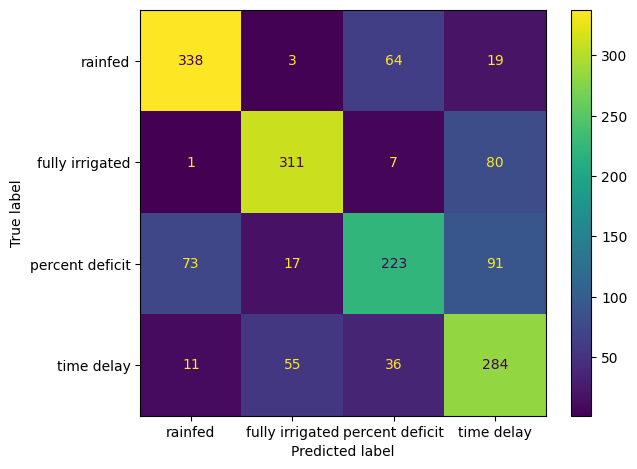

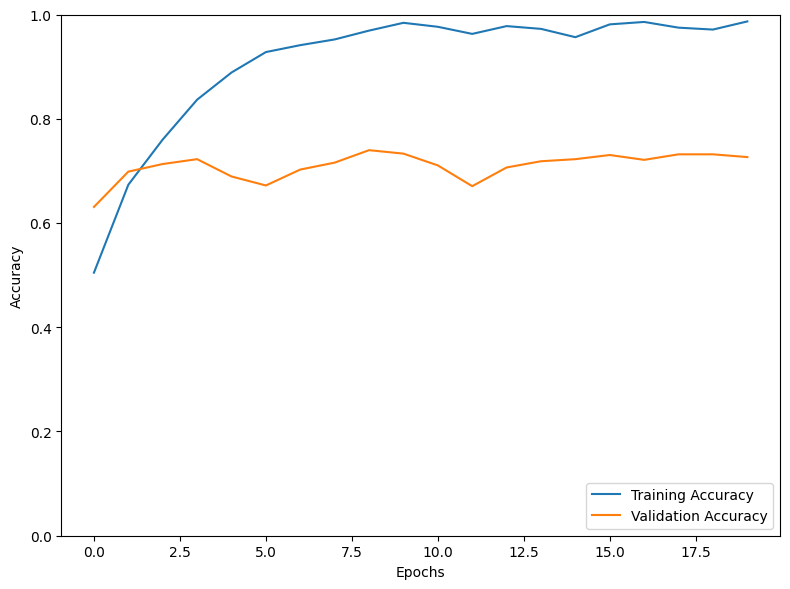

In [8]:
# MODEL EVALUATION
def evaluate_model(model, test_images, test_labels, date, history):
    print('> Evaluating the model ...')

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f"Test Accuracy for {date}: {test_acc:.2f}")

    # Predictions and classification report
    predictions = model.predict(test_images)
    pred_classes = np.argmax(predictions, axis=1)

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(test_labels, pred_classes, display_labels=class_names)
    save_fig(f"Confusion_matrix_{date}")

    # Classification report
    report = classification_report(test_labels, pred_classes, target_names=class_names)
    print(report)

    # Save the classification report
    report_path = f"{IMAGES_PATH}/Classification_Report_{date}.txt"
    with open(report_path, "w") as f:
        f.write(report)

    # Plot training history
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    save_fig(f"Training_Accuracy_{date}")

    return predictions

predictions = evaluate_model(model, test_images, test_labels, date, history)


### Single Prediction & Visualisation

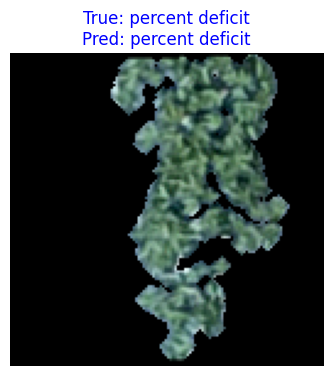

In [9]:
def visualize_predictions(test_images, test_labels, predictions, class_names, idx=None):
    # If idx is not provided, pick a random index
    if idx is None:
        idx = np.random.randint(len(test_images))  # Uncomment for random
    # idx = 0  # Uncomment for static choice (e.g., first image)

    plt.figure(figsize=(10, 10))

    # Prediction visualization
    plt.subplot(1, 3, 2)
    true_label = class_names[test_labels[idx]]
    predicted_label = class_names[np.argmax(predictions[idx])]
    plt.imshow(test_images[idx])
    plt.title(f"True: {true_label}\nPred: {predicted_label}", 
              color='blue' if true_label == predicted_label else 'red')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize results for one image (static idx or random)
visualize_predictions(test_images, test_labels, predictions, class_names)